In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd

# Scripting experiments

With the new and improved `obd_run.py` and `Experiment` class (see Experiment Interface notebook), we can easily script end to end experiments.

## An OpenBanditDataset experiment

An OpenBanditDataset experiment requires a `dataset_spec.yaml`, `estimator_spec.yaml`, and `policy_spec.yaml`, where the `policy_spec.yaml` can be a _list_ of policies. 

In [2]:
!ls ../experiments/obd_demo/

dataset_spec.yaml   estimator_spec.yaml policy_spec.yaml


In [3]:
!cat ../experiments/obd_demo/policy_spec.yaml

- key: BernoulliTS
  name: obd_demo
  parameters:
    batch_size: 5
    len_list: 3
    n_actions: 3
  type: policy
- key: LinUCB
  name: obd_demo
  parameters:
    dim: 27
    batch_size: 5
    len_list: 3
    n_actions: 3
  type: policy


Then we just point `obp_run.py` at the experiment directory and let it do it's thing!

In [4]:
!python ../scripting/obp_run.py --experiment-dir ../experiments/obd_demo

9:58:54 INFO: Building dataset
9:58:56 INFO: Building policies
9:58:56 INFO: Building estimators
9:58:56 INFO: Running experiment
9:58:56 INFO: Obtaining logged feedback
9:58:56 INFO: Done in 0.0 seconds
9:58:56 INFO: Fitting regression model
9:59:04 INFO: Done in 7.76 seconds
9:59:04 INFO: Running simulations
9:59:04 INFO: [1 of 2] Running simulation for bts
100%|████████████████████████████████| 452949/452949 [00:13<00:00, 32636.61it/s]
9:59:19 INFO: [2 of 2] Running simulation for linear_ucb_0.0
100%|████████████████████████████████| 452949/452949 [00:36<00:00, 12432.60it/s]
9:59:56 INFO: Done in 51.41 seconds
9:59:56 INFO: Estimating rewards
9:59:56 INFO: Estimating reward confidence interval for logged feedback
9:59:56 INFO: [1 of 2] Estimating reward confidence interval for bts
10:00:57 INFO: [2 of 2] Estimating reward confidence interval for linear_ucb_0.0
10:02:00 INFO: Done in 124.57 seconds
10:02:00 INFO: Experiment finished in 183.74 seconds
10:02:00 INFO: Writing output to 

It drops a `results.pickle` file in the experiments directory with the `OBDExperiment` object.

In [5]:
with open("../experiments/obd_demo/results.pickle","rb") as f:
    obd_results = pickle.load(f)

OBD experiments use off-policy estimators, so we just get a confidence interval for each policy as output:

In [6]:
obd_results.rewards

{'logged': {'mean': 0.005124417980832279,
  '95.0% CI (lower)': 0.004902925053372455,
  '95.0% CI (upper)': 0.0053510991303656694},
 'bts': {'mean': 0.00541277551078753,
  '95.0% CI (lower)': 0.0054070022780304105,
  '95.0% CI (upper)': 0.005418496385973897},
 'linear_ucb_0.0': {'mean': 0.005327403099059197,
  '95.0% CI (lower)': 0.005321834978560733,
  '95.0% CI (upper)': 0.005333151384723679}}

## A Deezer experiment

Deezer experiments only require a `dataset_spec.yaml` and `policy_spec.yaml`, since they don't use off-policy estimators.

In [7]:
!ls ../experiments/deezer_demo

dataset_spec.yaml policy_spec.yaml


In [8]:
!python ../scripting/obp_run.py --experiment-dir ../experiments/deezer_demo

10:02:07 INFO: Building dataset
10:02:24 INFO: Building policies
10:02:24 INFO: Running experiment
10:02:24 INFO: Obtaining random baseline feedback
Calculating click probabilities: 100%|█| 100000/100000 [00:16<00:00, 6157.31it/s
Generating feedback: 100%|███████████| 100000/100000 [00:03<00:00, 30689.28it/s]
10:02:45 INFO: Done in 20.93 seconds
10:02:45 INFO: Learning and obtaining policy feedback
10:02:45 INFO: [1 of 2] Learning and obtaining bts feedback
Simulating online learning: 100%|█████| 100000/100000 [00:30<00:00, 3305.76it/s]
10:03:16 INFO: [2 of 2] Learning and obtaining egreedy_0.1 feedback
Simulating online learning: 100%|█████| 100000/100000 [00:19<00:00, 5176.87it/s]
10:03:37 INFO: Done in 52.89 seconds
10:03:37 INFO: Estimating reward confidence interval for random baseline feedback
10:03:38 INFO: [1 of 2] Estimating reward confindence interval for bts feedback
10:03:39 INFO: [2 of 2] Estimating reward confindence interval for egreedy_0.1 feedback
10:03:40 INFO: Done i

Once again we get a `results.pickle` file.

In [9]:
with open("../experiments/deezer_demo/results.pickle","rb") as f:
    deezer_results = pickle.load(f)

We have the rewards intervals:

In [10]:
deezer_results.rewards

{'random': {'mean': 0.02699252613151486,
  '95.0% CI (lower)': 0.026517594669501272,
  '95.0% CI (upper)': 0.027457833749215527},
 'bts': {'mean': 0.25231972103413514,
  '95.0% CI (lower)': 0.25093674231073093,
  '95.0% CI (upper)': 0.2537817037622252},
 'egreedy_0.1': {'mean': 0.06192555479448775,
  '95.0% CI (lower)': 0.06117091214775998,
  '95.0% CI (upper)': 0.06255089308380953}}

But sice we learned our bandits online, we also have their rewards as they learned:

In [11]:
bts = pd.DataFrame(
    {
        "reward": deezer_results.policy_feedback["bts"]["reward"],
        "batch": deezer_results.policy_feedback["bts"]["batches"],
        "pol": "bts"
    }
)
eps = pd.DataFrame(
    {
        "reward": deezer_results.policy_feedback["egreedy_0.1"]["reward"],
        "batch": deezer_results.policy_feedback["egreedy_0.1"]["batches"],
        "pol": "egreedy_0.1"
    }
)


Text(0, 0.5, 'cumulative rewards')

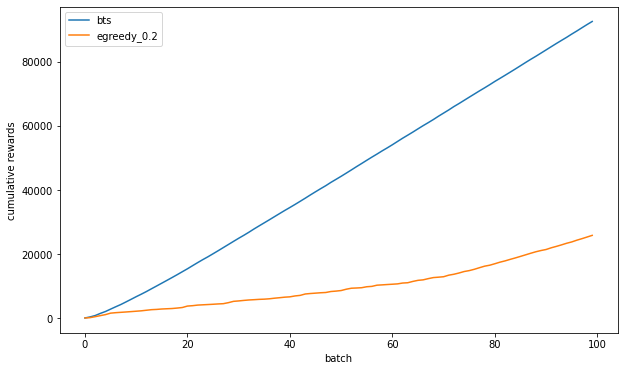

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bts.groupby("batch").sum().cumsum(), label="bts")
ax.plot(eps.groupby("batch").sum().cumsum(), label="egreedy_0.2")
ax.legend()
ax.set_xlabel("batch")
ax.set_ylabel("cumulative rewards")